# Gradiente de política (REINFORCE)

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="cart_pole.gif" width="400">

Objetivo: usar o gradiente de política de Monte Carlo (episódico), conhecido como REINFORCE, para estimar uma política $\pi(a|s, \boldsymbol{\theta})$ que controle um pêndulo invertido.

## Características do pêndulo:

### Espaço de observações

| Número | Observação | Min | Max |
| :-: | :- | :-: | :-: |
| 0	| Posição do carrinho | -4.8 | 4.8|
| 1	| Velocidade do carrinho | $-\infty$ | $\infty$|
| 2	| Ângulo do pêndulo | -0.418 rad (-24°)	| 0.418 rad (24°)|
| 3	| Velocidade angular do pêndulo	| $-\infty$ | $\infty$ |

### Espaço de ações
| Número | Ação |
| :-: | :- |
| 0	| Carrinho para a esquerda |
| 1	| Carrinho para a direita |

### Função de recompensa

- Devolve +1 para cada passo antes do pêndulo cair.
- Episódio termina quando o ângulo do pêndulo excede ±12°, ou quando a posição do carrinho é maior que ±2.4.
- Máximo de 200 passos.

Importando as bibliotecas.

In [1]:
try:
    import gymnasium as gym
except:
    import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,4)

Essa rede representa uma função diferenciável $\pi(a|s, \boldsymbol{\theta})$ que fornece a probabilidade de cada ação $a$ ser escolhida, dado um estado $s$. A arquitetura da Rede Neural Artificial (Perceptron) tem ```state_size``` entradas, ```action_size``` saídas e uma camada escondida de tamanho ```hidden_size```.

In [2]:
class Policy(nn.Module):
    ##########################################
    def __init__(self, state_size, action_size, hidden_size=16, device='cpu'):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
        # baseline: função de valor
        self.value_head = nn.Linear(hidden_size, 1)
        
        # usa gpu?
        self.device = device

    ##########################################
    def forward(self, state):
        x = F.relu(self.fc1(state))
        # probabilidade das acoes
        action_probs = F.softmax(self.fc2(x), dim=1)
        # valor do estado
        state_value = self.value_head(x)
        return action_probs, state_value

    ##########################################
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        # saida da rede é a probabilidade de cada ação para o estado
        probs, value = self.forward(state)
        # escolhe a ação aleatoria segundo a probabilidade categorical
        model = Categorical(probs)
        action = model.sample()
        # retorna ação e log da probabilidade dela
        return action.item(), model.log_prob(action), value

Criando a classe para o algoritmo de REINFORCE.

In [3]:
class Reinforce(object):
    def __init__(self, parameters):
        
        self.parameters = parameters

        # numero de episodios
        self.episode = 0
        self.max_iter = parameters['max_iter']
        
        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.beta = parameters['beta']
        self.device = parameters['device']
        self.baseline = parameters['baseline']

        # cria ambiente
        if parameters['render']:
            self.env = gym.make('CartPole-v1', render_mode='human')
        else:
            self.env = gym.make('CartPole-v1')
        
        # cria a função parametrica da política
        self.policy = Policy(state_size=self.env.observation_space.shape[0], action_size=self.env.action_space.n, device=self.device).to(self.device)
        
        # otimizador da rede neural
        self.optimizer = optim.Adam(self.policy.parameters(), lr=self.beta)

Executando um episódio.

In [4]:
class Reinforce(Reinforce):
    ##########################################
    def runEpisode(self):
        
        # novo episodio
        self.episode += 1
        
        saved_log_probs = []
        rewards = []
        values = []

        # reseta o ambiente
        S, _ = self.env.reset()

        # Gerando a experiencia a partir da politica
        for _ in range(self.max_iter):

            # Amostra uma ação da politica corrente
            A, log_prob, state_value = self.policy.act(S)
            saved_log_probs.append(log_prob)
            values.append(state_value)

            # passo de interacao com o ambiente
            Sl, R, done, _, _ = self.env.step(A)
            rewards.append(R)
            
            # chegou a um estado terminal?
            if done: 
                break
                
            # proximo estado
            S = Sl

        # Calcula o retorno aplicando o fator de desconto
        Gs = []
        G = 0
        for r in rewards:
            G = r + self.gamma * G
            Gs.insert(0, G)
        Gs = torch.tensor(Gs, dtype=torch.float32).to(self.device)
        
        # Observe que estamos usando Gradiente Ascendente (não Descendente), logo, usamos o negativo do retorno.
        if self.baseline:
            # Perda da política usando advantage
            Vs = torch.cat(values).squeeze().detach()
            As = Gs - Vs
            policy_loss = torch.stack([-log_prob*adv for log_prob, adv in zip(saved_log_probs, As)])
        else:
            # Perda da política usando apenas o retorno
            policy_loss = torch.stack([-log_prob*G   for log_prob, G   in zip(saved_log_probs, Gs)])

        # Concatenando a política em uma dimensão
        loss = policy_loss.sum()
        
        # Perda da função de valor (baseline)
        if self.baseline:
            value_loss = F.mse_loss(Vs, Gs)
            loss = loss + value_loss  # junta as perdas

        # Algoritmo de backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return np.sum(np.array(rewards))

Programa principal:
- episodes: número de episódios
- max_iter: máximo de iterações até o fim do episódio
- n_agents: roda $n$ agentes ao mesmo tempo e observa a média
- gamma: fator de desconto
- beta: $\beta$
- baseline: usa baseline (vantagem)
- device: usa *cpu* ou *gpu*
- render: renderiza animação

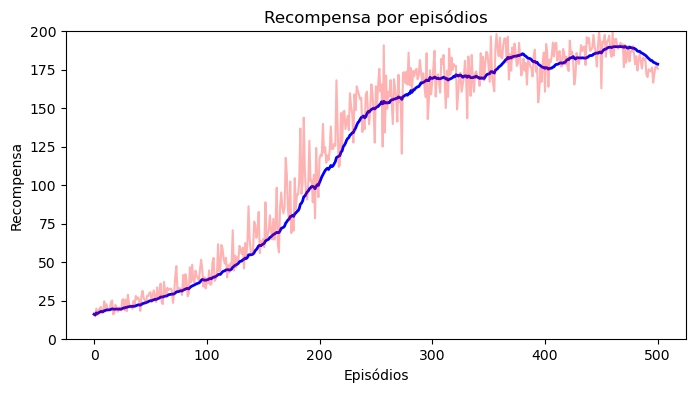

In [5]:
if __name__ == '__main__':
    
    plt.ion()
    
    # parametros
    parameters = {'episodes'  : 500,
                  'max_iter'  : 200,
                  'n_agents'  : 10,
                  'gamma'     : 0.99,
                  'beta'      : 5e-3,
                  'baseline'  : False,
                  'device'    : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                  'render'    : False,
                 }
    
    # historico dos reforços
    rewards = []
    avg_rewards = []
    
    # cria 'n_agents' para observar comportamento médio
    re = [Reinforce(parameters) for _ in range(parameters['n_agents'])]
    
    while re[0].episode <= parameters['episodes']:
        
        # roda um episodio para cada agente
        total_reward = [re[i].runEpisode() for i in range(parameters['n_agents'])]
        # média de todos os agentes
        total_reward = np.mean(total_reward)

        # rewards
        rewards.append(total_reward)
        # reward medio
        avg_rewards.append(np.mean(rewards[-25:]))

        plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        plt.plot(avg_rewards, 'b', linewidth=2)
        plt.plot(rewards, 'r', alpha=0.3)
        plt.title('Recompensa por episódios')
        plt.xlabel('Episódios')
        plt.ylabel('Recompensa')
        plt.ylim([0, 200])

        plt.show()
        plt.pause(.1)

    plt.ioff()